# **DSCI 552 - Final Project**

Name : Maitrri Jayant Chandra

USC ID : 1526957373

GitHub Username : Maitrri2711

## 1. Transfer Learning for Image Classification

In [1]:
# Data Handling & Preprocessing
import zipfile
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import cv2
import random

# Deep Learning Framework (TensorFlow & Keras)
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Pretrained CNN Architectures
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16

# Evaluation & Visualization
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Warning
import warnings
warnings.filterwarnings('ignore')

Extracting the datasets from Zip file

In [4]:
# This piece of code was used only for extracting the folders; since we are working with the extracted files going forward, it is no longer needed.
# # Defining the path to the zip file and the destination extraction folder
# zip_path = '../data/RealWaste.zip'
# extract_to = '../data'  # This will be the output folder

# # Creating the destination directory if it doesn't already exist
# os.makedirs(extract_to, exist_ok=True)

# # Extracting all contents of the zip file to the specified directory
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# # Printing confirmation of successful extraction
# print(f"Extraction complete. Files extracted to: {extract_to}")

### (1)(a)

In this problem, we are trying to build a classifier that distinguishes images of nine types of waste.

### (1)(b) Data Exploration and Pre-processing

#### (1)(b)(i) Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding.

In [3]:
# Setting the base path where dataset folders are located
base_path = '../data'

# Getting all class folder names and sorting them alphabetically
class_folders = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

# Extracting class names from folder names (e.g., Cardboard, Glass)
class_labels = [folder.split('-')[1] for folder in class_folders]

# Creating one-hot encoded vectors for class labels
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(np.array(class_labels).reshape(-1, 1))

# Initializing lists to store training and test data
X_train, y_train, X_test, y_test = [], [], [], []

# Iterating through each class folder and its corresponding label
for folder, label_vec in zip(class_folders, encoded_labels):
    folder_path = os.path.join(base_path, folder)

    # Finding and numerically sorting all .jpg images in the folder
    images = sorted(glob.glob(os.path.join(folder_path, '*.jpg')), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

    # Splitting image list into 80% training and 20% testing
    split_index = int(0.8 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Adding image paths and labels to the dataset lists
    X_train.extend(train_images)
    y_train.extend([label_vec] * len(train_images))
    X_test.extend(test_images)
    y_test.extend([label_vec] * len(test_images))

# Converting lists to NumPy arrays for model compatibility
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Printing a summary of the dataset structure
print(f'Total classes: {len(class_labels)}')
print(f'Training samples: {len(X_train)}')
print(f'Test samples: {len(X_test)}')

Total classes: 9
Training samples: 3798
Test samples: 954


#### (1)(b)(ii) In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [9]:
# Setting the target image size (width, height) for resizing
IMAGE_SIZE = (224, 224)

# Defining directories for saving processed training and test images
processed_dir_train = 'processed_train'
processed_dir_test = 'processed_test'

# Creating directories to save processed images if they don't exist already
os.makedirs(processed_dir_train, exist_ok=True)
os.makedirs(processed_dir_test, exist_ok=True)

# Helper function: resizing images while preserving aspect ratio and adding zero padding
def resize_with_padding(image, target_size):
    old_h, old_w = image.shape[:2]
    new_w, new_h = target_size

    # Calculating scaling factor for resizing
    scale = min(new_w / old_w, new_h / old_h)
    resized_img = cv2.resize(image, (int(old_w * scale), int(old_h * scale)))

    # Calculating padding to ensure the image fits the target size
    delta_w = new_w - resized_img.shape[1]
    delta_h = new_h - resized_img.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # Applying padding to the resized image
    padded_img = cv2.copyMakeBorder(resized_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img

# Processing training images by resizing and padding
X_train_processed = []
for i, path in enumerate(X_train):
    img = cv2.imread(path)
    if img is not None:
        processed_img = resize_with_padding(img, IMAGE_SIZE)
        X_train_processed.append(processed_img)
        
        # Saving processed training image with a new name
        filename = os.path.join(processed_dir_train, f"train_{i:04d}.jpg")  # Saving the processed image
        cv2.imwrite(filename, processed_img)

# Processing test images by resizing and padding
X_test_processed = []
for i, path in enumerate(X_test):
    img = cv2.imread(path)
    if img is not None:
        processed_img = resize_with_padding(img, IMAGE_SIZE)
        X_test_processed.append(processed_img)
        
        # Saving processed test image with a new name
        filename = os.path.join(processed_dir_test, f"test_{i:04d}.jpg")  # Saving the processed image
        cv2.imwrite(filename, processed_img)

# Replacing original lists with processed image arrays
X_train = np.array(X_train_processed)
X_test = np.array(X_test_processed)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Outputting the shapes of processed datasets for confirmation
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3798, 224, 224, 3), y_train shape: (3798, 9)
X_test shape: (954, 224, 224, 3), y_test shape: (954, 9)


### (1)(c) Transfer Learning

#### (1)(c)(i)
When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

**Note :**
The models **ResNet50, ResNet101 (used instead of ResNet100 as it doesn't exist), EfficientNetB0 and VGG16** are implemented in section **1.c.iii** of the code.

#### (1)(c)(ii) To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [51]:
# Defining function for random cropping of images while preserving crop size
def random_crop(img, crop_size=(224, 224)):
    h, w = img.shape[:2]
    ch, cw = crop_size
    if h < ch or w < cw:
        return cv2.resize(img, crop_size)
    x = random.randint(0, w - cw)
    y = random.randint(0, h - ch)
    return img[y:y+ch, x:x+cw]

# Defining function for random zooming of images within the specified range
def random_zoom(img, zoom_range=(0.8, 1.2)):
    h, w = img.shape[:2]
    zoom = random.uniform(*zoom_range)
    new_h, new_w = int(h * zoom), int(w * zoom)
    img_zoomed = cv2.resize(img, (new_w, new_h))
    if zoom < 1:
        pad_h = (h - new_h) // 2
        pad_w = (w - new_w) // 2
        img_zoomed = cv2.copyMakeBorder(img_zoomed, pad_h, h - new_h - pad_h, pad_w, w - new_w - pad_w, cv2.BORDER_CONSTANT, value=[0,0,0])
    else:
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        img_zoomed = img_zoomed[start_h:start_h+h, start_w:start_w+w]
    return img_zoomed

# Defining function for random rotating images within a specified angle range
def random_rotate(img, angle_range=(-25, 25)):
    angle = random.uniform(*angle_range)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# Defining function for randomly flipping images (horizontal, vertical, both, or none)
def random_flip(img):
    flip_code = random.choice([-1, 0, 1, None])  # horizontal, vertical, both, or none
    if flip_code is not None:
        return cv2.flip(img, flip_code)
    return img

# Defining function for randomly adjusting image contrast and brightness
def random_contrast(img, alpha_range=(0.8, 1.2), beta_range=(-20, 20)):
    alpha = random.uniform(*alpha_range)
    beta = random.randint(*beta_range)
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

# Defining function for random translation (shifting) of images
def random_translate(img, max_shift=20):
    h, w = img.shape[:2]
    tx = random.randint(-max_shift, max_shift)
    ty = random.randint(-max_shift, max_shift)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

# Creating a directory to store augmented training images
augmented_dir_train = 'augmented_train'
os.makedirs(augmented_dir_train, exist_ok=True)

# Initializing list to store augmented training images
X_train_augmented = []

# Iterating over each image in the training dataset
for i, img in enumerate(X_train):
    aug_img = img.copy()
    
    # Applying various augmentations on each image
    aug_img = random_crop(aug_img, crop_size=(200, 200))  # Cropping image
    aug_img = cv2.resize(aug_img, IMAGE_SIZE)  # Resizing image to target size
    aug_img = random_zoom(aug_img)  # Zooming image
    aug_img = random_rotate(aug_img)  # Rotating image
    aug_img = random_flip(aug_img)  # Flipping image
    aug_img = random_contrast(aug_img)  # Adjusting contrast and brightness
    aug_img = random_translate(aug_img)  # Translating (shifting) image
    
    # Appending augmented image to list and saving it
    X_train_augmented.append(aug_img)
    filename = os.path.join(augmented_dir_train, f"aug_train_{i:04d}.jpg")
    cv2.imwrite(filename, aug_img)

# Converting the augmented images list into a NumPy array
X_train_augmented = np.array(X_train_augmented)

# Printing the shape of the augmented training dataset
print(f"Augmented training images shape: {X_train_augmented.shape}")

Augmented training images shape: (3798, 224, 224, 3)


#### (1)(c)(iii) Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization 3, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [52]:
# Defining the input shape and number of classes based on one-hot encoded labels
input_shape = (224, 224, 3)
num_classes = y_train.shape[1]  # Ensuring that y_train is already one-hot encoded

# Building the transfer learning model using a base model architecture
def build_transfer_model(base_model_fn, input_shape, num_classes):
    # Loading the base model without the top layer, using pre-trained weights
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freezing all pre-trained layers to avoid retraining

    # Defining the input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Passing input through the base model (pre-trained layers)
    x = base_model(inputs, training=False)
    
    # Applying global average pooling to reduce the spatial dimensions
    x = layers.GlobalAveragePooling2D()(x)
    
    # Adding batch normalization for stability
    x = layers.BatchNormalization()(x)
    
    # Adding dropout layer to prevent overfitting
    x = layers.Dropout(0.2)(x)
    
    # Adding a fully connected layer with L2 regularization
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    # Applying batch normalization again
    x = layers.BatchNormalization()(x)
    
    # Adding another dropout layer
    x = layers.Dropout(0.2)(x)
    
    # Adding the output layer with a softmax activation function for multi-class classification
    x = layers.Dense(num_classes, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    
    # Applying final batch normalization
    x = layers.BatchNormalization()(x)
    
    # Final softmax output layer for classification
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Creating the model from input and output layers
    model = models.Model(inputs, outputs)
    
    # Compiling the model with Adam optimizer and categorical crossentropy loss function
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [55]:
# Initializing and summarizing the ResNet50 transfer learning model.
print("Training ResNet50\n")
model = build_transfer_model(ResNet50, input_shape, num_classes)
model.summary()

Training ResNet50



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,859,975 (91.02 MB)

 Trainable params: 267,893 (1.02 MB)

 Non-trainable params: 23,592,082 (90.00 MB)

In [56]:
# Initializing and summarizing the ResNet101 transfer learning model.
print("Training ResNet101\n")
model = build_transfer_model(ResNet101, input_shape, num_classes)
model.summary()

Training ResNet101



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,930,439 (163.77 MB)

 Trainable params: 267,893 (1.02 MB)

 Non-trainable params: 42,662,546 (162.74 MB)

In [57]:
# Initializing and summarizing the EfficientNetB0 transfer learning model.
print("Training EfficientNetB0\n")
model = build_transfer_model(EfficientNetB0, input_shape, num_classes)
model.summary()

Training EfficientNetB0



Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,220,458 (16.10 MB)

 Trainable params: 168,053 (656.46 KB)

 Non-trainable params: 4,052,405 (15.46 MB)

In [58]:
# Initializing and summarizing the VGG16 transfer learning model.
print("Training VGG16\n")
model = build_transfer_model(VGG16, input_shape, num_classes)
model.summary()

Training VGG16



Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │         1,161 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 9)              │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,784,199 (56.40 MB)

 Trainable params: 68,213 (266.46 KB)

 Non-trainable params: 14,715,986 (56.14 MB)

#### (1)(c)(iv) Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

In [70]:
# Stratified split to ensure the class distribution is consistent across training and validation sets (20% validation split)
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_augmented, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Function to train the model with the specified base model, input shape, and number of classes
def run_model(name, input_shape, num_classes):
    print(f"\nTraining {name.__name__}")  # Printing the name of the model being trained
    
    # Build the model using transfer learning
    model = build_transfer_model(name, input_shape, num_classes)
    
    # Early stopping callback to stop training if the validation loss doesn't improve for 10 epochs
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Model checkpoint callback to save the best model based on validation loss
    checkpoint = ModelCheckpoint(f'best_{name.__name__}.h5', monitor='val_loss', save_best_only=True)
    
    # Train the model with the training data, validation data, and callbacks
    history = model.fit(
        X_train_split, y_train_split,
        epochs=100,
        batch_size=5,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],  # Applying early stopping and checkpoint
        verbose=2  # Set verbosity level to 2 for detailed output
    )
    
    # Plotting the training and validation loss curves
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Training Loss')  # Plotting the training loss curve
    plt.plot(history.history['val_loss'], label='Validation Loss')  # Plotting the validation loss curve
    plt.xlabel('Epoch')  # Labeling x-axis as 'Epoch'
    plt.ylabel('Loss')  # Labeling y-axis as 'Loss'
    plt.title(f'Training and Validation Loss: {name.__name__}')  # Setting plot title
    plt.legend()  # Adding legend to the plot
    plt.show()  # Displaying the plot


Training ResNet50
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.2917 - loss: 4.4724

608/608 ━━━━━━━━━━━━━━━━━━━━ 244s 388ms/step - accuracy: 0.2918 - loss: 4.4717 - val_accuracy: 0.5382 - val_loss: 3.1114
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.5070 - loss: 3.0390

608/608 ━━━━━━━━━━━━━━━━━━━━ 221s 363ms/step - accuracy: 0.5069 - loss: 3.0388 - val_accuracy: 0.6171 - val_loss: 2.2984
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.5710 - loss: 2.4585

608/608 ━━━━━━━━━━━━━━━━━━━━ 206s 339ms/step - accuracy: 0.5709 - loss: 2.4585 - val_accuracy: 0.6276 - val_loss: 2.1022
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5582 - loss: 2.2648

608/608 ━━━━━━━━━━━━━━━━━━━━ 302s 405ms/step - accuracy: 0.5583 - loss: 2.2647 - val_accuracy: 0.6461 - val_loss: 2.0523
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5801 - loss: 2.2148

608/608 ━━━━━━━━━━━━━━━━━━━━ 244s 401ms/step - accuracy: 0.5801 - loss: 2.2148 - val_accuracy: 0.6487 - val_loss: 1.9693
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.6024 - loss: 2.1665

608/608 ━━━━━━━━━━━━━━━━━━━━ 563s 927ms/step - accuracy: 0.6024 - loss: 2.1665 - val_accuracy: 0.6750 - val_loss: 1.9531
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 223s 367ms/step - accuracy: 0.5984 - loss: 2.1558 - val_accuracy: 0.6618 - val_loss: 1.9776
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6230 - loss: 2.1009

608/608 ━━━━━━━━━━━━━━━━━━━━ 238s 392ms/step - accuracy: 0.6230 - loss: 2.1010 - val_accuracy: 0.6974 - val_loss: 1.9185
Epoch 9/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5946 - loss: 2.1279

608/608 ━━━━━━━━━━━━━━━━━━━━ 423s 696ms/step - accuracy: 0.5946 - loss: 2.1278 - val_accuracy: 0.6645 - val_loss: 1.8860
Epoch 10/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 233s 382ms/step - accuracy: 0.6066 - loss: 2.1019 - val_accuracy: 0.6737 - val_loss: 1.9193
Epoch 11/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 161s 265ms/step - accuracy: 0.6123 - loss: 2.0870 - val_accuracy: 0.6842 - val_loss: 1.8949
Epoch 12/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 156s 257ms/step - accuracy: 0.6044 - loss: 2.0822 - val_accuracy: 0.6855 - val_loss: 1.9016
Epoch 13/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - accuracy: 0.6149 - loss: 2.0906 - val_accuracy: 0.6855 - val_loss: 1.9264
Epoch 14/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - accuracy: 0.6180 - loss: 2.0865 - val_accuracy: 0.6816 - val_loss: 1.9015
Epoch 15/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - accuracy: 0.6160 - loss: 2.0359 - val_accuracy: 0.6421 - val_loss: 1.9245
Epoch 16/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 155s 255ms/step - accuracy: 0.625

608/608 ━━━━━━━━━━━━━━━━━━━━ 176s 290ms/step - accuracy: 0.6184 - loss: 2.0348 - val_accuracy: 0.6855 - val_loss: 1.8141
Epoch 19/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 153s 252ms/step - accuracy: 0.6208 - loss: 1.9988 - val_accuracy: 0.6895 - val_loss: 1.8351
Epoch 20/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6376 - loss: 1.9943

608/608 ━━━━━━━━━━━━━━━━━━━━ 153s 251ms/step - accuracy: 0.6376 - loss: 1.9943 - val_accuracy: 0.6618 - val_loss: 1.8011
Epoch 21/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6450 - loss: 1.9643

608/608 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - accuracy: 0.6449 - loss: 1.9644 - val_accuracy: 0.6868 - val_loss: 1.7714
Epoch 22/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6194 - loss: 1.9530

608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 239ms/step - accuracy: 0.6194 - loss: 1.9531 - val_accuracy: 0.6816 - val_loss: 1.7696
Epoch 23/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/step - accuracy: 0.6283 - loss: 1.9259 - val_accuracy: 0.6539 - val_loss: 1.8622
Epoch 24/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 238ms/step - accuracy: 0.6210 - loss: 1.9590 - val_accuracy: 0.6579 - val_loss: 1.8389
Epoch 25/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 147s 242ms/step - accuracy: 0.6200 - loss: 1.9705 - val_accuracy: 0.6947 - val_loss: 1.7769
Epoch 26/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6270 - loss: 1.9177

608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.6270 - loss: 1.9178 - val_accuracy: 0.7066 - val_loss: 1.7227
Epoch 27/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.6504 - loss: 1.9111 - val_accuracy: 0.6934 - val_loss: 1.7498
Epoch 28/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 238ms/step - accuracy: 0.6294 - loss: 1.9003 - val_accuracy: 0.6829 - val_loss: 1.8039
Epoch 29/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6473 - loss: 1.8728

608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.6473 - loss: 1.8728 - val_accuracy: 0.6842 - val_loss: 1.7146
Epoch 30/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/step - accuracy: 0.6207 - loss: 1.8959 - val_accuracy: 0.6724 - val_loss: 1.7794
Epoch 31/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 238ms/step - accuracy: 0.6336 - loss: 1.9110 - val_accuracy: 0.7000 - val_loss: 1.7598
Epoch 32/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.6711 - loss: 1.8437 - val_accuracy: 0.6816 - val_loss: 1.7390
Epoch 33/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - accuracy: 0.6573 - loss: 1.8165 - val_accuracy: 0.6855 - val_loss: 1.7423
Epoch 34/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.6369 - loss: 1.8697 - val_accuracy: 0.6961 - val_loss: 1.7319
Epoch 35/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 238ms/step - accuracy: 0.6391 - loss: 1.8377 - val_accuracy: 0.6776 - val_loss: 1.7382
Epoch 36/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6485 

608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 238ms/step - accuracy: 0.6485 - loss: 1.8343 - val_accuracy: 0.7092 - val_loss: 1.6759
Epoch 37/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6374 - loss: 1.8500

608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 238ms/step - accuracy: 0.6374 - loss: 1.8500 - val_accuracy: 0.6934 - val_loss: 1.6393
Epoch 38/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 147s 242ms/step - accuracy: 0.6589 - loss: 1.7605 - val_accuracy: 0.6855 - val_loss: 1.6922
Epoch 39/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.6633 - loss: 1.7938 - val_accuracy: 0.7026 - val_loss: 1.6819
Epoch 40/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6454 - loss: 1.7723

608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.6454 - loss: 1.7723 - val_accuracy: 0.7224 - val_loss: 1.5499
Epoch 41/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 236ms/step - accuracy: 0.6562 - loss: 1.7483 - val_accuracy: 0.7053 - val_loss: 1.6376
Epoch 42/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6382 - loss: 1.7180 - val_accuracy: 0.6974 - val_loss: 1.6255
Epoch 43/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6527 - loss: 1.7247

608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 236ms/step - accuracy: 0.6526 - loss: 1.7247 - val_accuracy: 0.7224 - val_loss: 1.5444
Epoch 44/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6674 - loss: 1.6474 - val_accuracy: 0.6908 - val_loss: 1.5752
Epoch 45/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.6484 - loss: 1.6637 - val_accuracy: 0.6632 - val_loss: 1.6003
Epoch 46/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6694 - loss: 1.6713 - val_accuracy: 0.6855 - val_loss: 1.6284
Epoch 47/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 236ms/step - accuracy: 0.6790 - loss: 1.6731 - val_accuracy: 0.7066 - val_loss: 1.5480
Epoch 48/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6802 - loss: 1.6085 - val_accuracy: 0.6842 - val_loss: 1.5819
Epoch 49/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 233ms/step - accuracy: 0.6602 - loss: 1.6586 - val_accuracy: 0.7145 - val_loss: 1.5895
Epoch 50/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 231ms/step - accuracy: 0.661

608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.6664 - loss: 1.6526 - val_accuracy: 0.7013 - val_loss: 1.5084
Epoch 52/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6629 - loss: 1.6161

608/608 ━━━━━━━━━━━━━━━━━━━━ 147s 241ms/step - accuracy: 0.6629 - loss: 1.6161 - val_accuracy: 0.7079 - val_loss: 1.4785
Epoch 53/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 150s 246ms/step - accuracy: 0.6515 - loss: 1.6373 - val_accuracy: 0.6921 - val_loss: 1.4982
Epoch 54/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6705 - loss: 1.5676

608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.6705 - loss: 1.5676 - val_accuracy: 0.7145 - val_loss: 1.4530
Epoch 55/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.6617 - loss: 1.5621 - val_accuracy: 0.6974 - val_loss: 1.5032
Epoch 56/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 231ms/step - accuracy: 0.6943 - loss: 1.5370 - val_accuracy: 0.7211 - val_loss: 1.4964
Epoch 57/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.6912 - loss: 1.4798

608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 235ms/step - accuracy: 0.6912 - loss: 1.4799 - val_accuracy: 0.7026 - val_loss: 1.4379
Epoch 58/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 149s 244ms/step - accuracy: 0.6560 - loss: 1.5224 - val_accuracy: 0.6974 - val_loss: 1.4816
Epoch 59/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6843 - loss: 1.5148

608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.6843 - loss: 1.5149 - val_accuracy: 0.6987 - val_loss: 1.4231
Epoch 60/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.6718 - loss: 1.5164 - val_accuracy: 0.6921 - val_loss: 1.4921
Epoch 61/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 164s 269ms/step - accuracy: 0.6599 - loss: 1.4781 - val_accuracy: 0.6842 - val_loss: 1.4754
Epoch 62/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6668 - loss: 1.5028

608/608 ━━━━━━━━━━━━━━━━━━━━ 173s 285ms/step - accuracy: 0.6667 - loss: 1.5029 - val_accuracy: 0.7053 - val_loss: 1.3937
Epoch 63/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 173s 284ms/step - accuracy: 0.6607 - loss: 1.5400 - val_accuracy: 0.6934 - val_loss: 1.4487
Epoch 64/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.6585 - loss: 1.5303

608/608 ━━━━━━━━━━━━━━━━━━━━ 173s 284ms/step - accuracy: 0.6585 - loss: 1.5303 - val_accuracy: 0.7105 - val_loss: 1.3899
Epoch 65/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 170s 279ms/step - accuracy: 0.6684 - loss: 1.5376 - val_accuracy: 0.6974 - val_loss: 1.4434
Epoch 66/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 172s 284ms/step - accuracy: 0.6729 - loss: 1.4727 - val_accuracy: 0.6947 - val_loss: 1.4954
Epoch 67/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 170s 280ms/step - accuracy: 0.6587 - loss: 1.5595 - val_accuracy: 0.6934 - val_loss: 1.4178
Epoch 68/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 171s 281ms/step - accuracy: 0.6581 - loss: 1.4675 - val_accuracy: 0.6895 - val_loss: 1.4233
Epoch 69/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 169s 278ms/step - accuracy: 0.6816 - loss: 1.4289 - val_accuracy: 0.7039 - val_loss: 1.4517
Epoch 70/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.6635 - loss: 1.4936

608/608 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.6635 - loss: 1.4936 - val_accuracy: 0.7118 - val_loss: 1.3459
Epoch 71/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 139s 229ms/step - accuracy: 0.6767 - loss: 1.4673 - val_accuracy: 0.7026 - val_loss: 1.3897
Epoch 72/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.6553 - loss: 1.4687 - val_accuracy: 0.6934 - val_loss: 1.3529
Epoch 73/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.6714 - loss: 1.4505 - val_accuracy: 0.6868 - val_loss: 1.4029
Epoch 74/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.6730 - loss: 1.4209 - val_accuracy: 0.6750 - val_loss: 1.3460
Epoch 75/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6567 - loss: 1.4255

608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.6567 - loss: 1.4255 - val_accuracy: 0.7145 - val_loss: 1.3154
Epoch 76/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 241ms/step - accuracy: 0.6745 - loss: 1.3930 - val_accuracy: 0.7013 - val_loss: 1.3608
Epoch 77/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 149s 245ms/step - accuracy: 0.6779 - loss: 1.3938 - val_accuracy: 0.7013 - val_loss: 1.3401
Epoch 78/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 144s 237ms/step - accuracy: 0.6697 - loss: 1.4049 - val_accuracy: 0.7145 - val_loss: 1.3231
Epoch 79/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 143s 235ms/step - accuracy: 0.6795 - loss: 1.3919 - val_accuracy: 0.7079 - val_loss: 1.3336
Epoch 80/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.6814 - loss: 1.4046 - val_accuracy: 0.6947 - val_loss: 1.3377
Epoch 81/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 148s 244ms/step - accuracy: 0.6731 - loss: 1.4051 - val_accuracy: 0.6961 - val_loss: 1.3207
Epoch 82/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6639 

608/608 ━━━━━━━━━━━━━━━━━━━━ 147s 242ms/step - accuracy: 0.6639 - loss: 1.4278 - val_accuracy: 0.6974 - val_loss: 1.3023
Epoch 83/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6820 - loss: 1.3743

608/608 ━━━━━━━━━━━━━━━━━━━━ 368s 606ms/step - accuracy: 0.6820 - loss: 1.3744 - val_accuracy: 0.7000 - val_loss: 1.3012
Epoch 84/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6883 - loss: 1.3265

608/608 ━━━━━━━━━━━━━━━━━━━━ 132s 217ms/step - accuracy: 0.6883 - loss: 1.3266 - val_accuracy: 0.7013 - val_loss: 1.2928
Epoch 85/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6722 - loss: 1.3676

608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 232ms/step - accuracy: 0.6722 - loss: 1.3676 - val_accuracy: 0.7092 - val_loss: 1.2418
Epoch 86/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.6835 - loss: 1.3493 - val_accuracy: 0.7053 - val_loss: 1.3421
Epoch 87/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.6709 - loss: 1.3890 - val_accuracy: 0.6908 - val_loss: 1.2675
Epoch 88/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 145s 239ms/step - accuracy: 0.6714 - loss: 1.3876 - val_accuracy: 0.7066 - val_loss: 1.2902
Epoch 89/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 137s 226ms/step - accuracy: 0.6816 - loss: 1.3742 - val_accuracy: 0.6921 - val_loss: 1.3091
Epoch 90/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 140s 231ms/step - accuracy: 0.6594 - loss: 1.4357 - val_accuracy: 0.6974 - val_loss: 1.2974
Epoch 91/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.6721 - loss: 1.3675 - val_accuracy: 0.7000 - val_loss: 1.3019
Epoch 92/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 140s 230ms/step - accuracy: 0.670

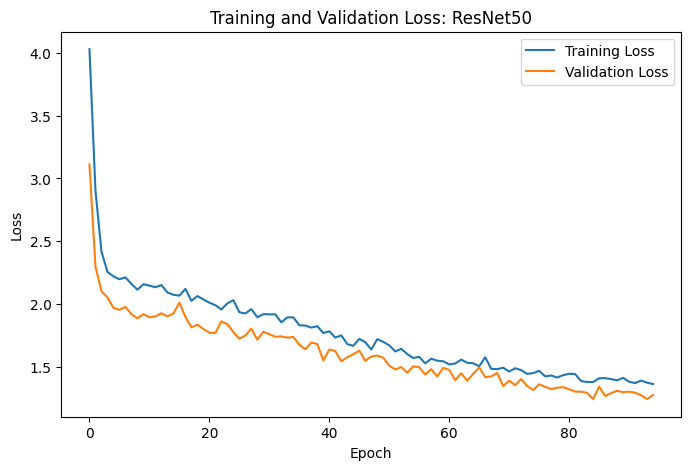

In [60]:
# Training ResNet50 with loss visualization
run_model(ResNet50, input_shape, num_classes)


Training ResNet101
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.3062 - loss: 4.4519

608/608 ━━━━━━━━━━━━━━━━━━━━ 320s 512ms/step - accuracy: 0.3063 - loss: 4.4513 - val_accuracy: 0.5329 - val_loss: 3.2211
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4709 - loss: 3.1760

608/608 ━━━━━━━━━━━━━━━━━━━━ 274s 451ms/step - accuracy: 0.4709 - loss: 3.1757 - val_accuracy: 0.5921 - val_loss: 2.4964
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5403 - loss: 2.5831

608/608 ━━━━━━━━━━━━━━━━━━━━ 282s 464ms/step - accuracy: 0.5403 - loss: 2.5830 - val_accuracy: 0.6592 - val_loss: 2.1508
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.5778 - loss: 2.3057

608/608 ━━━━━━━━━━━━━━━━━━━━ 274s 450ms/step - accuracy: 0.5777 - loss: 2.3057 - val_accuracy: 0.6579 - val_loss: 2.0288
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5826 - loss: 2.2549

608/608 ━━━━━━━━━━━━━━━━━━━━ 269s 442ms/step - accuracy: 0.5826 - loss: 2.2549 - val_accuracy: 0.6803 - val_loss: 2.0101
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 269s 443ms/step - accuracy: 0.6065 - loss: 2.1989 - val_accuracy: 0.6395 - val_loss: 2.1030
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5935 - loss: 2.2459

608/608 ━━━━━━━━━━━━━━━━━━━━ 271s 446ms/step - accuracy: 0.5935 - loss: 2.2460 - val_accuracy: 0.6882 - val_loss: 1.9855
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 268s 441ms/step - accuracy: 0.6052 - loss: 2.2044 - val_accuracy: 0.6671 - val_loss: 2.0371
Epoch 9/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6163 - loss: 2.1396

608/608 ━━━━━━━━━━━━━━━━━━━━ 267s 440ms/step - accuracy: 0.6163 - loss: 2.1397 - val_accuracy: 0.6829 - val_loss: 1.9536
Epoch 10/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.6346 - loss: 2.0845

608/608 ━━━━━━━━━━━━━━━━━━━━ 271s 445ms/step - accuracy: 0.6346 - loss: 2.0846 - val_accuracy: 0.6882 - val_loss: 1.9161
Epoch 11/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6208 - loss: 2.0838

608/608 ━━━━━━━━━━━━━━━━━━━━ 268s 441ms/step - accuracy: 0.6207 - loss: 2.0838 - val_accuracy: 0.6553 - val_loss: 1.9059
Epoch 12/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 274s 452ms/step - accuracy: 0.6067 - loss: 2.2010 - val_accuracy: 0.7000 - val_loss: 1.9393
Epoch 13/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 268s 440ms/step - accuracy: 0.6269 - loss: 2.1101 - val_accuracy: 0.6724 - val_loss: 1.9448
Epoch 14/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6293 - loss: 2.1069

608/608 ━━━━━━━━━━━━━━━━━━━━ 332s 546ms/step - accuracy: 0.6293 - loss: 2.1070 - val_accuracy: 0.6987 - val_loss: 1.8986
Epoch 15/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6253 - loss: 2.0366

608/608 ━━━━━━━━━━━━━━━━━━━━ 273s 449ms/step - accuracy: 0.6252 - loss: 2.0367 - val_accuracy: 0.6934 - val_loss: 1.8749
Epoch 16/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 270s 444ms/step - accuracy: 0.6277 - loss: 2.0423 - val_accuracy: 0.6671 - val_loss: 1.9198
Epoch 17/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6191 - loss: 2.0767

608/608 ━━━━━━━━━━━━━━━━━━━━ 267s 439ms/step - accuracy: 0.6190 - loss: 2.0767 - val_accuracy: 0.6882 - val_loss: 1.8486
Epoch 18/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6515 - loss: 1.9597

608/608 ━━━━━━━━━━━━━━━━━━━━ 262s 431ms/step - accuracy: 0.6514 - loss: 1.9598 - val_accuracy: 0.6789 - val_loss: 1.8441
Epoch 19/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 264s 434ms/step - accuracy: 0.6223 - loss: 2.0553 - val_accuracy: 0.7039 - val_loss: 1.8563
Epoch 20/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 265s 436ms/step - accuracy: 0.6183 - loss: 2.0616 - val_accuracy: 0.6829 - val_loss: 1.8653
Epoch 21/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 265s 436ms/step - accuracy: 0.6397 - loss: 1.9726 - val_accuracy: 0.7026 - val_loss: 1.8542
Epoch 22/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6370 - loss: 2.0540

608/608 ━━━━━━━━━━━━━━━━━━━━ 265s 437ms/step - accuracy: 0.6370 - loss: 2.0540 - val_accuracy: 0.6842 - val_loss: 1.8199
Epoch 23/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6420 - loss: 1.9400

608/608 ━━━━━━━━━━━━━━━━━━━━ 267s 440ms/step - accuracy: 0.6420 - loss: 1.9401 - val_accuracy: 0.6934 - val_loss: 1.8118
Epoch 24/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6153 - loss: 1.9770

608/608 ━━━━━━━━━━━━━━━━━━━━ 265s 436ms/step - accuracy: 0.6153 - loss: 1.9770 - val_accuracy: 0.7053 - val_loss: 1.7434
Epoch 25/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 270s 445ms/step - accuracy: 0.6365 - loss: 1.9243 - val_accuracy: 0.6895 - val_loss: 1.7647
Epoch 26/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 264s 434ms/step - accuracy: 0.6439 - loss: 1.9262 - val_accuracy: 0.6882 - val_loss: 1.8337
Epoch 27/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 280s 461ms/step - accuracy: 0.6594 - loss: 1.9027 - val_accuracy: 0.6750 - val_loss: 1.8496
Epoch 28/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 591s 972ms/step - accuracy: 0.6504 - loss: 1.8865 - val_accuracy: 0.6724 - val_loss: 1.8069
Epoch 29/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 257s 422ms/step - accuracy: 0.6480 - loss: 1.8863 - val_accuracy: 0.6947 - val_loss: 1.7870
Epoch 30/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6069 - loss: 1.9965

608/608 ━━━━━━━━━━━━━━━━━━━━ 257s 423ms/step - accuracy: 0.6069 - loss: 1.9965 - val_accuracy: 0.7039 - val_loss: 1.7182
Epoch 31/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6326 - loss: 1.9180

608/608 ━━━━━━━━━━━━━━━━━━━━ 256s 421ms/step - accuracy: 0.6326 - loss: 1.9179 - val_accuracy: 0.7105 - val_loss: 1.7055
Epoch 32/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 258s 424ms/step - accuracy: 0.6383 - loss: 1.8426 - val_accuracy: 0.6908 - val_loss: 1.7267
Epoch 33/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6296 - loss: 1.9283

608/608 ━━━━━━━━━━━━━━━━━━━━ 258s 424ms/step - accuracy: 0.6296 - loss: 1.9283 - val_accuracy: 0.7026 - val_loss: 1.7028
Epoch 34/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 261s 429ms/step - accuracy: 0.6674 - loss: 1.7926 - val_accuracy: 0.7026 - val_loss: 1.7548
Epoch 35/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 269s 442ms/step - accuracy: 0.6505 - loss: 1.8471 - val_accuracy: 0.6842 - val_loss: 1.7101
Epoch 36/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6466 - loss: 1.8126

608/608 ━━━━━━━━━━━━━━━━━━━━ 265s 436ms/step - accuracy: 0.6466 - loss: 1.8125 - val_accuracy: 0.6921 - val_loss: 1.6887
Epoch 37/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6469 - loss: 1.7605

608/608 ━━━━━━━━━━━━━━━━━━━━ 350s 576ms/step - accuracy: 0.6469 - loss: 1.7606 - val_accuracy: 0.6961 - val_loss: 1.6877
Epoch 38/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.6505 - loss: 1.8012

608/608 ━━━━━━━━━━━━━━━━━━━━ 347s 570ms/step - accuracy: 0.6505 - loss: 1.8012 - val_accuracy: 0.6921 - val_loss: 1.6730
Epoch 39/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6613 - loss: 1.7545

608/608 ━━━━━━━━━━━━━━━━━━━━ 337s 554ms/step - accuracy: 0.6612 - loss: 1.7545 - val_accuracy: 0.6961 - val_loss: 1.6717
Epoch 40/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.6556 - loss: 1.7892

608/608 ━━━━━━━━━━━━━━━━━━━━ 346s 568ms/step - accuracy: 0.6556 - loss: 1.7893 - val_accuracy: 0.6816 - val_loss: 1.6478
Epoch 41/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6283 - loss: 1.8318

608/608 ━━━━━━━━━━━━━━━━━━━━ 341s 561ms/step - accuracy: 0.6283 - loss: 1.8317 - val_accuracy: 0.7118 - val_loss: 1.5942
Epoch 42/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 353s 581ms/step - accuracy: 0.6618 - loss: 1.6960 - val_accuracy: 0.7105 - val_loss: 1.7074
Epoch 43/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 368s 606ms/step - accuracy: 0.6889 - loss: 1.6751 - val_accuracy: 0.6934 - val_loss: 1.6187
Epoch 44/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.6539 - loss: 1.7399

608/608 ━━━━━━━━━━━━━━━━━━━━ 377s 620ms/step - accuracy: 0.6539 - loss: 1.7399 - val_accuracy: 0.6961 - val_loss: 1.5933
Epoch 45/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 395s 650ms/step - accuracy: 0.6757 - loss: 1.6800 - val_accuracy: 0.7026 - val_loss: 1.6022
Epoch 46/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6579 - loss: 1.6808

608/608 ━━━━━━━━━━━━━━━━━━━━ 389s 640ms/step - accuracy: 0.6579 - loss: 1.6808 - val_accuracy: 0.7026 - val_loss: 1.5111
Epoch 47/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 409s 672ms/step - accuracy: 0.6856 - loss: 1.6000 - val_accuracy: 0.6882 - val_loss: 1.5909
Epoch 48/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 388s 638ms/step - accuracy: 0.6747 - loss: 1.6664 - val_accuracy: 0.6868 - val_loss: 1.5423
Epoch 49/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - accuracy: 0.6779 - loss: 1.6262

608/608 ━━━━━━━━━━━━━━━━━━━━ 397s 653ms/step - accuracy: 0.6779 - loss: 1.6262 - val_accuracy: 0.7092 - val_loss: 1.5033
Epoch 50/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 393s 646ms/step - accuracy: 0.6676 - loss: 1.6381 - val_accuracy: 0.6842 - val_loss: 1.5601
Epoch 51/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 716ms/step - accuracy: 0.6649 - loss: 1.6176 - val_accuracy: 0.6947 - val_loss: 1.5307
Epoch 52/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 461s 758ms/step - accuracy: 0.6673 - loss: 1.6274 - val_accuracy: 0.7171 - val_loss: 1.5175
Epoch 53/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 461s 758ms/step - accuracy: 0.6820 - loss: 1.5740 - val_accuracy: 0.6855 - val_loss: 1.5595
Epoch 54/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 495s 814ms/step - accuracy: 0.6647 - loss: 1.6222 - val_accuracy: 0.6816 - val_loss: 1.5216
Epoch 55/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 400s 658ms/step - accuracy: 0.7067 - loss: 1.5161 - val_accuracy: 0.6842 - val_loss: 1.5332
Epoch 56/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.6692 

608/608 ━━━━━━━━━━━━━━━━━━━━ 397s 653ms/step - accuracy: 0.6692 - loss: 1.6185 - val_accuracy: 0.7105 - val_loss: 1.4390
Epoch 57/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.6859 - loss: 1.5217

608/608 ━━━━━━━━━━━━━━━━━━━━ 385s 633ms/step - accuracy: 0.6859 - loss: 1.5218 - val_accuracy: 0.7105 - val_loss: 1.4364
Epoch 58/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 718ms/step - accuracy: 0.6863 - loss: 1.5285 - val_accuracy: 0.6934 - val_loss: 1.4547
Epoch 59/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.6843 - loss: 1.4757

608/608 ━━━━━━━━━━━━━━━━━━━━ 402s 662ms/step - accuracy: 0.6842 - loss: 1.4758 - val_accuracy: 0.7263 - val_loss: 1.4093
Epoch 60/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 460s 757ms/step - accuracy: 0.6884 - loss: 1.4786 - val_accuracy: 0.6566 - val_loss: 1.5557
Epoch 61/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 405s 666ms/step - accuracy: 0.6556 - loss: 1.5999 - val_accuracy: 0.7066 - val_loss: 1.4361
Epoch 62/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 404s 603ms/step - accuracy: 0.7044 - loss: 1.4331 - val_accuracy: 0.6961 - val_loss: 1.4357
Epoch 63/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 377s 620ms/step - accuracy: 0.6821 - loss: 1.4787 - val_accuracy: 0.7079 - val_loss: 1.4632
Epoch 64/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 485s 798ms/step - accuracy: 0.6887 - loss: 1.4560 - val_accuracy: 0.7066 - val_loss: 1.4224
Epoch 65/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 456s 750ms/step - accuracy: 0.6610 - loss: 1.4757 - val_accuracy: 0.7118 - val_loss: 1.4495
Epoch 66/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 376s 618ms/step - accuracy: 0.685

608/608 ━━━━━━━━━━━━━━━━━━━━ 410s 675ms/step - accuracy: 0.6729 - loss: 1.4714 - val_accuracy: 0.7184 - val_loss: 1.3904
Epoch 69/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 349s 573ms/step - accuracy: 0.6884 - loss: 1.4963 - val_accuracy: 0.6961 - val_loss: 1.4129
Epoch 70/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 360s 592ms/step - accuracy: 0.6858 - loss: 1.4689 - val_accuracy: 0.6855 - val_loss: 1.4266
Epoch 71/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 366s 602ms/step - accuracy: 0.6913 - loss: 1.4335 - val_accuracy: 0.6829 - val_loss: 1.4585
Epoch 72/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6752 - loss: 1.4723

608/608 ━━━━━━━━━━━━━━━━━━━━ 353s 580ms/step - accuracy: 0.6752 - loss: 1.4724 - val_accuracy: 0.7079 - val_loss: 1.3698
Epoch 73/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 449s 738ms/step - accuracy: 0.6658 - loss: 1.4697 - val_accuracy: 0.6921 - val_loss: 1.4015
Epoch 74/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 540s 889ms/step - accuracy: 0.6819 - loss: 1.4319 - val_accuracy: 0.6711 - val_loss: 1.4472
Epoch 75/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 428s 705ms/step - accuracy: 0.6647 - loss: 1.4550 - val_accuracy: 0.6934 - val_loss: 1.3774
Epoch 76/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 406s 668ms/step - accuracy: 0.6547 - loss: 1.4318 - val_accuracy: 0.6908 - val_loss: 1.4036
Epoch 77/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.6995 - loss: 1.3630

608/608 ━━━━━━━━━━━━━━━━━━━━ 410s 675ms/step - accuracy: 0.6995 - loss: 1.3631 - val_accuracy: 0.7145 - val_loss: 1.3511
Epoch 78/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 413s 680ms/step - accuracy: 0.6849 - loss: 1.4254 - val_accuracy: 0.7000 - val_loss: 1.3991
Epoch 79/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 670ms/step - accuracy: 0.6927 - loss: 1.3723 - val_accuracy: 0.6934 - val_loss: 1.3742
Epoch 80/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6587 - loss: 1.4503

608/608 ━━━━━━━━━━━━━━━━━━━━ 415s 682ms/step - accuracy: 0.6587 - loss: 1.4503 - val_accuracy: 0.7197 - val_loss: 1.3406
Epoch 81/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 411s 676ms/step - accuracy: 0.6899 - loss: 1.3901 - val_accuracy: 0.7079 - val_loss: 1.3757
Epoch 82/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 417s 687ms/step - accuracy: 0.6793 - loss: 1.3628 - val_accuracy: 0.7013 - val_loss: 1.3770
Epoch 83/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 410s 675ms/step - accuracy: 0.6645 - loss: 1.4162 - val_accuracy: 0.6974 - val_loss: 1.3561
Epoch 84/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6635 - loss: 1.4110

608/608 ━━━━━━━━━━━━━━━━━━━━ 418s 688ms/step - accuracy: 0.6635 - loss: 1.4110 - val_accuracy: 0.6987 - val_loss: 1.3356
Epoch 85/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6882 - loss: 1.3450

608/608 ━━━━━━━━━━━━━━━━━━━━ 427s 702ms/step - accuracy: 0.6882 - loss: 1.3450 - val_accuracy: 0.7105 - val_loss: 1.3211
Epoch 86/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 419s 690ms/step - accuracy: 0.6723 - loss: 1.3734 - val_accuracy: 0.6803 - val_loss: 1.3804
Epoch 87/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 528s 868ms/step - accuracy: 0.6737 - loss: 1.3998 - val_accuracy: 0.6947 - val_loss: 1.3433
Epoch 88/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.6896 - loss: 1.3470

608/608 ━━━━━━━━━━━━━━━━━━━━ 555s 912ms/step - accuracy: 0.6896 - loss: 1.3469 - val_accuracy: 0.7211 - val_loss: 1.2859
Epoch 89/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7033 - loss: 1.3221

608/608 ━━━━━━━━━━━━━━━━━━━━ 559s 908ms/step - accuracy: 0.7033 - loss: 1.3222 - val_accuracy: 0.7158 - val_loss: 1.2543
Epoch 90/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 552s 909ms/step - accuracy: 0.6900 - loss: 1.3059 - val_accuracy: 0.7184 - val_loss: 1.2658
Epoch 91/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 559s 919ms/step - accuracy: 0.6766 - loss: 1.3277 - val_accuracy: 0.6842 - val_loss: 1.3167
Epoch 92/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 548s 902ms/step - accuracy: 0.6778 - loss: 1.3565 - val_accuracy: 0.7118 - val_loss: 1.2926
Epoch 93/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 548s 902ms/step - accuracy: 0.6822 - loss: 1.3519 - val_accuracy: 0.7211 - val_loss: 1.2710
Epoch 94/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.7190 - loss: 1.2511

608/608 ━━━━━━━━━━━━━━━━━━━━ 546s 899ms/step - accuracy: 0.7189 - loss: 1.2512 - val_accuracy: 0.7066 - val_loss: 1.2390
Epoch 95/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 544s 896ms/step - accuracy: 0.6766 - loss: 1.3476 - val_accuracy: 0.7184 - val_loss: 1.2792
Epoch 96/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 541s 890ms/step - accuracy: 0.6888 - loss: 1.3002 - val_accuracy: 0.7079 - val_loss: 1.2802
Epoch 97/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 555s 913ms/step - accuracy: 0.6779 - loss: 1.3474 - val_accuracy: 0.7026 - val_loss: 1.2804
Epoch 98/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 542s 891ms/step - accuracy: 0.6768 - loss: 1.3511 - val_accuracy: 0.7066 - val_loss: 1.2875
Epoch 99/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 546s 897ms/step - accuracy: 0.7024 - loss: 1.2865 - val_accuracy: 0.7211 - val_loss: 1.2585
Epoch 100/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 543s 894ms/step - accuracy: 0.6809 - loss: 1.3390 - val_accuracy: 0.7079 - val_loss: 1.2432


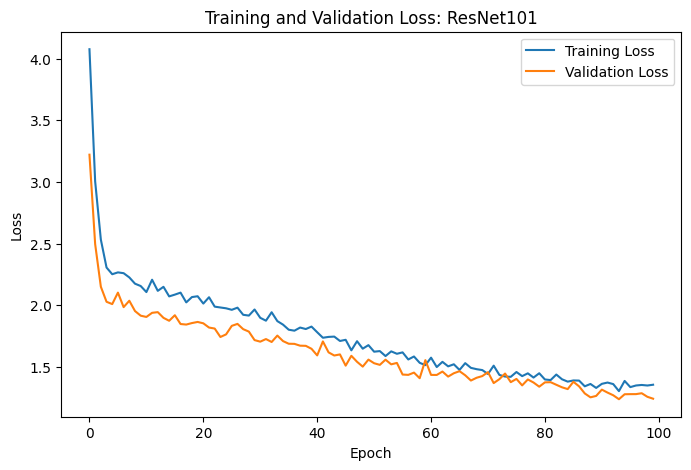

In [61]:
# Training ResNet101 with loss visualization
run_model(ResNet101, input_shape, num_classes)


Training EfficientNetB0
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2923 - loss: 4.2959

608/608 ━━━━━━━━━━━━━━━━━━━━ 108s 164ms/step - accuracy: 0.2925 - loss: 4.2952 - val_accuracy: 0.5987 - val_loss: 2.8657
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5004 - loss: 2.9387

608/608 ━━━━━━━━━━━━━━━━━━━━ 95s 157ms/step - accuracy: 0.5004 - loss: 2.9385 - val_accuracy: 0.6263 - val_loss: 2.2441
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5582 - loss: 2.3789

608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.5582 - loss: 2.3788 - val_accuracy: 0.6645 - val_loss: 1.8979
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6010 - loss: 2.1030

608/608 ━━━━━━━━━━━━━━━━━━━━ 97s 159ms/step - accuracy: 0.6010 - loss: 2.1030 - val_accuracy: 0.6803 - val_loss: 1.7981
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5907 - loss: 2.0553

608/608 ━━━━━━━━━━━━━━━━━━━━ 98s 161ms/step - accuracy: 0.5907 - loss: 2.0553 - val_accuracy: 0.7039 - val_loss: 1.7703
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5957 - loss: 2.0443

608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.5957 - loss: 2.0442 - val_accuracy: 0.6934 - val_loss: 1.7236
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 97s 159ms/step - accuracy: 0.6162 - loss: 1.9574 - val_accuracy: 0.6776 - val_loss: 1.7951
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 98s 161ms/step - accuracy: 0.6210 - loss: 1.9930 - val_accuracy: 0.6921 - val_loss: 1.7961
Epoch 9/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5891 - loss: 2.0371

608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.5892 - loss: 2.0371 - val_accuracy: 0.7184 - val_loss: 1.6638
Epoch 10/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 98s 160ms/step - accuracy: 0.6258 - loss: 1.9202 - val_accuracy: 0.7211 - val_loss: 1.6867
Epoch 11/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6150 - loss: 1.9241

608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.6150 - loss: 1.9241 - val_accuracy: 0.7000 - val_loss: 1.6607
Epoch 12/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.6266 - loss: 1.9527 - val_accuracy: 0.7158 - val_loss: 1.7060
Epoch 13/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 164ms/step - accuracy: 0.6378 - loss: 1.9421 - val_accuracy: 0.6987 - val_loss: 1.6761
Epoch 14/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6219 - loss: 1.9513

608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.6219 - loss: 1.9513 - val_accuracy: 0.7092 - val_loss: 1.6184
Epoch 15/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 105s 172ms/step - accuracy: 0.6264 - loss: 1.8891 - val_accuracy: 0.7079 - val_loss: 1.6351
Epoch 16/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 113s 186ms/step - accuracy: 0.6237 - loss: 1.8837 - val_accuracy: 0.7000 - val_loss: 1.6295
Epoch 17/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.6219 - loss: 1.9119 - val_accuracy: 0.7066 - val_loss: 1.6259
Epoch 18/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.6021 - loss: 1.9458 - val_accuracy: 0.7026 - val_loss: 1.6611
Epoch 19/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6166 - loss: 1.9088

608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 166ms/step - accuracy: 0.6166 - loss: 1.9087 - val_accuracy: 0.7224 - val_loss: 1.5680
Epoch 20/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.6284 - loss: 1.8071 - val_accuracy: 0.7092 - val_loss: 1.5907
Epoch 21/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6315 - loss: 1.8376

608/608 ━━━━━━━━━━━━━━━━━━━━ 104s 171ms/step - accuracy: 0.6315 - loss: 1.8377 - val_accuracy: 0.7158 - val_loss: 1.5625
Epoch 22/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6407 - loss: 1.7993

608/608 ━━━━━━━━━━━━━━━━━━━━ 103s 170ms/step - accuracy: 0.6407 - loss: 1.7993 - val_accuracy: 0.7197 - val_loss: 1.5352
Epoch 23/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 166ms/step - accuracy: 0.6473 - loss: 1.7697 - val_accuracy: 0.6974 - val_loss: 1.6690
Epoch 24/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6511 - loss: 1.7903

608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.6511 - loss: 1.7903 - val_accuracy: 0.7250 - val_loss: 1.5284
Epoch 25/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.6420 - loss: 1.7857 - val_accuracy: 0.7026 - val_loss: 1.5965
Epoch 26/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 99s 163ms/step - accuracy: 0.6382 - loss: 1.8112 - val_accuracy: 0.7237 - val_loss: 1.5397
Epoch 27/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 166ms/step - accuracy: 0.6587 - loss: 1.7390 - val_accuracy: 0.7184 - val_loss: 1.6066
Epoch 28/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 102s 167ms/step - accuracy: 0.6552 - loss: 1.7900 - val_accuracy: 0.7184 - val_loss: 1.5821
Epoch 29/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6332 - loss: 1.7983

608/608 ━━━━━━━━━━━━━━━━━━━━ 102s 167ms/step - accuracy: 0.6332 - loss: 1.7983 - val_accuracy: 0.7000 - val_loss: 1.4978
Epoch 30/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 102s 168ms/step - accuracy: 0.6606 - loss: 1.7572 - val_accuracy: 0.7224 - val_loss: 1.5230
Epoch 31/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 104s 170ms/step - accuracy: 0.6383 - loss: 1.8060 - val_accuracy: 0.7105 - val_loss: 1.5279
Epoch 32/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 100s 165ms/step - accuracy: 0.6358 - loss: 1.7318 - val_accuracy: 0.7079 - val_loss: 1.5566
Epoch 33/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 103s 170ms/step - accuracy: 0.6458 - loss: 1.7371 - val_accuracy: 0.6882 - val_loss: 1.5920
Epoch 34/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 103s 169ms/step - accuracy: 0.6482 - loss: 1.7270 - val_accuracy: 0.7026 - val_loss: 1.5336
Epoch 35/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6370 - loss: 1.7142

608/608 ━━━━━━━━━━━━━━━━━━━━ 105s 172ms/step - accuracy: 0.6370 - loss: 1.7142 - val_accuracy: 0.7118 - val_loss: 1.4796
Epoch 36/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6582 - loss: 1.6757

608/608 ━━━━━━━━━━━━━━━━━━━━ 107s 177ms/step - accuracy: 0.6582 - loss: 1.6757 - val_accuracy: 0.7303 - val_loss: 1.4309
Epoch 37/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 125s 205ms/step - accuracy: 0.6624 - loss: 1.6445 - val_accuracy: 0.7368 - val_loss: 1.4324
Epoch 38/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 124s 204ms/step - accuracy: 0.6536 - loss: 1.6619 - val_accuracy: 0.7132 - val_loss: 1.4680
Epoch 39/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6287 - loss: 1.7276

608/608 ━━━━━━━━━━━━━━━━━━━━ 123s 203ms/step - accuracy: 0.6287 - loss: 1.7276 - val_accuracy: 0.7158 - val_loss: 1.4176
Epoch 40/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - accuracy: 0.6353 - loss: 1.6756 - val_accuracy: 0.7171 - val_loss: 1.4817
Epoch 41/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.6566 - loss: 1.6406 - val_accuracy: 0.7039 - val_loss: 1.4242
Epoch 42/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.6636 - loss: 1.6010 - val_accuracy: 0.7026 - val_loss: 1.4570
Epoch 43/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6459 - loss: 1.6110

608/608 ━━━━━━━━━━━━━━━━━━━━ 131s 215ms/step - accuracy: 0.6459 - loss: 1.6110 - val_accuracy: 0.7224 - val_loss: 1.4176
Epoch 44/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 122s 201ms/step - accuracy: 0.6437 - loss: 1.6152 - val_accuracy: 0.7132 - val_loss: 1.4436
Epoch 45/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 123s 202ms/step - accuracy: 0.6611 - loss: 1.5884 - val_accuracy: 0.7039 - val_loss: 1.4697
Epoch 46/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6635 - loss: 1.6191

608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6634 - loss: 1.6191 - val_accuracy: 0.7289 - val_loss: 1.3713
Epoch 47/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.6703 - loss: 1.5347 - val_accuracy: 0.7276 - val_loss: 1.3896
Epoch 48/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6572 - loss: 1.5562

608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.6572 - loss: 1.5563 - val_accuracy: 0.7289 - val_loss: 1.3252
Epoch 49/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6631 - loss: 1.5569 - val_accuracy: 0.7000 - val_loss: 1.3863
Epoch 50/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6722 - loss: 1.5173 - val_accuracy: 0.7132 - val_loss: 1.3807
Epoch 51/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6462 - loss: 1.6066 - val_accuracy: 0.7171 - val_loss: 1.3460
Epoch 52/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 197ms/step - accuracy: 0.6675 - loss: 1.5473 - val_accuracy: 0.7145 - val_loss: 1.3387
Epoch 53/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 198ms/step - accuracy: 0.6580 - loss: 1.5196 - val_accuracy: 0.7158 - val_loss: 1.3391
Epoch 54/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6727 - loss: 1.4940 - val_accuracy: 0.6961 - val_loss: 1.3403
Epoch 55/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.670

608/608 ━━━━━━━━━━━━━━━━━━━━ 122s 200ms/step - accuracy: 0.6586 - loss: 1.5352 - val_accuracy: 0.7053 - val_loss: 1.3081
Epoch 57/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 120s 198ms/step - accuracy: 0.6513 - loss: 1.5124 - val_accuracy: 0.7171 - val_loss: 1.3389
Epoch 58/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6607 - loss: 1.4899

608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 200ms/step - accuracy: 0.6607 - loss: 1.4898 - val_accuracy: 0.7237 - val_loss: 1.2802
Epoch 59/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 198ms/step - accuracy: 0.6753 - loss: 1.4684 - val_accuracy: 0.7184 - val_loss: 1.3500
Epoch 60/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6507 - loss: 1.5145

608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 199ms/step - accuracy: 0.6507 - loss: 1.5145 - val_accuracy: 0.7184 - val_loss: 1.2701
Epoch 61/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6734 - loss: 1.4950

608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 200ms/step - accuracy: 0.6734 - loss: 1.4950 - val_accuracy: 0.7197 - val_loss: 1.2593
Epoch 62/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 121s 198ms/step - accuracy: 0.6455 - loss: 1.5304 - val_accuracy: 0.7013 - val_loss: 1.2966
Epoch 63/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6586 - loss: 1.4817

608/608 ━━━━━━━━━━━━━━━━━━━━ 128s 210ms/step - accuracy: 0.6586 - loss: 1.4818 - val_accuracy: 0.7276 - val_loss: 1.2368
Epoch 64/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 127s 209ms/step - accuracy: 0.6481 - loss: 1.5070 - val_accuracy: 0.7211 - val_loss: 1.2414
Epoch 65/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 116s 190ms/step - accuracy: 0.6482 - loss: 1.4646 - val_accuracy: 0.7026 - val_loss: 1.2857
Epoch 66/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6658 - loss: 1.4201

608/608 ━━━━━━━━━━━━━━━━━━━━ 112s 185ms/step - accuracy: 0.6658 - loss: 1.4201 - val_accuracy: 0.7237 - val_loss: 1.2270
Epoch 67/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 109s 180ms/step - accuracy: 0.6714 - loss: 1.4282 - val_accuracy: 0.7421 - val_loss: 1.2370
Epoch 68/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6618 - loss: 1.4045

608/608 ━━━━━━━━━━━━━━━━━━━━ 110s 181ms/step - accuracy: 0.6618 - loss: 1.4045 - val_accuracy: 0.7421 - val_loss: 1.2145
Epoch 69/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6695 - loss: 1.4173

608/608 ━━━━━━━━━━━━━━━━━━━━ 115s 189ms/step - accuracy: 0.6694 - loss: 1.4173 - val_accuracy: 0.7382 - val_loss: 1.1981
Epoch 70/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 85s 139ms/step - accuracy: 0.6995 - loss: 1.3400 - val_accuracy: 0.7237 - val_loss: 1.2088
Epoch 71/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 84s 138ms/step - accuracy: 0.6563 - loss: 1.4190 - val_accuracy: 0.7355 - val_loss: 1.2118
Epoch 72/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.6480 - loss: 1.4272

608/608 ━━━━━━━━━━━━━━━━━━━━ 87s 144ms/step - accuracy: 0.6480 - loss: 1.4273 - val_accuracy: 0.7329 - val_loss: 1.1875
Epoch 73/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6717 - loss: 1.3814

608/608 ━━━━━━━━━━━━━━━━━━━━ 88s 145ms/step - accuracy: 0.6717 - loss: 1.3814 - val_accuracy: 0.7421 - val_loss: 1.1819
Epoch 74/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6778 - loss: 1.3668

608/608 ━━━━━━━━━━━━━━━━━━━━ 86s 142ms/step - accuracy: 0.6778 - loss: 1.3669 - val_accuracy: 0.7329 - val_loss: 1.1814
Epoch 75/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 86s 142ms/step - accuracy: 0.6646 - loss: 1.3896 - val_accuracy: 0.7263 - val_loss: 1.2233
Epoch 76/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 88s 144ms/step - accuracy: 0.6727 - loss: 1.4000 - val_accuracy: 0.7132 - val_loss: 1.2264
Epoch 77/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 94s 155ms/step - accuracy: 0.6711 - loss: 1.3562 - val_accuracy: 0.7316 - val_loss: 1.2030
Epoch 78/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6797 - loss: 1.3767

608/608 ━━━━━━━━━━━━━━━━━━━━ 105s 173ms/step - accuracy: 0.6796 - loss: 1.3768 - val_accuracy: 0.7329 - val_loss: 1.1750
Epoch 79/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 107s 175ms/step - accuracy: 0.6473 - loss: 1.4140 - val_accuracy: 0.7066 - val_loss: 1.2446
Epoch 80/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 85s 140ms/step - accuracy: 0.6868 - loss: 1.3358 - val_accuracy: 0.7158 - val_loss: 1.1808
Epoch 81/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6757 - loss: 1.3569

608/608 ━━━━━━━━━━━━━━━━━━━━ 98s 162ms/step - accuracy: 0.6756 - loss: 1.3569 - val_accuracy: 0.7250 - val_loss: 1.1729
Epoch 82/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6832 - loss: 1.3173

608/608 ━━━━━━━━━━━━━━━━━━━━ 124s 132ms/step - accuracy: 0.6832 - loss: 1.3173 - val_accuracy: 0.7211 - val_loss: 1.1572
Epoch 83/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.6672 - loss: 1.3442

608/608 ━━━━━━━━━━━━━━━━━━━━ 102s 168ms/step - accuracy: 0.6672 - loss: 1.3442 - val_accuracy: 0.7316 - val_loss: 1.1352
Epoch 84/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 112s 184ms/step - accuracy: 0.6648 - loss: 1.3284 - val_accuracy: 0.7132 - val_loss: 1.2116
Epoch 85/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 95s 157ms/step - accuracy: 0.6664 - loss: 1.3626 - val_accuracy: 0.7276 - val_loss: 1.1546
Epoch 86/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 78s 127ms/step - accuracy: 0.6869 - loss: 1.2900 - val_accuracy: 0.7224 - val_loss: 1.1499
Epoch 87/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.6788 - loss: 1.3050 - val_accuracy: 0.7263 - val_loss: 1.1458
Epoch 88/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - accuracy: 0.6627 - loss: 1.3920 - val_accuracy: 0.7447 - val_loss: 1.1704
Epoch 89/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6580 - loss: 1.3752

608/608 ━━━━━━━━━━━━━━━━━━━━ 78s 129ms/step - accuracy: 0.6580 - loss: 1.3752 - val_accuracy: 0.7605 - val_loss: 1.1224
Epoch 90/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 76s 126ms/step - accuracy: 0.6789 - loss: 1.3196 - val_accuracy: 0.7355 - val_loss: 1.1432
Epoch 91/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6626 - loss: 1.3405 - val_accuracy: 0.7053 - val_loss: 1.1386
Epoch 92/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6590 - loss: 1.3443

608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6590 - loss: 1.3443 - val_accuracy: 0.7289 - val_loss: 1.1209
Epoch 93/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 127ms/step - accuracy: 0.6756 - loss: 1.2780 - val_accuracy: 0.7158 - val_loss: 1.1574
Epoch 94/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6924 - loss: 1.2706 - val_accuracy: 0.7421 - val_loss: 1.1604
Epoch 95/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6737 - loss: 1.3442 - val_accuracy: 0.7382 - val_loss: 1.1368
Epoch 96/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6530 - loss: 1.3657

608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 127ms/step - accuracy: 0.6530 - loss: 1.3657 - val_accuracy: 0.7355 - val_loss: 1.1027
Epoch 97/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6605 - loss: 1.3164 - val_accuracy: 0.7303 - val_loss: 1.1202
Epoch 98/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 76s 126ms/step - accuracy: 0.6864 - loss: 1.3101 - val_accuracy: 0.7263 - val_loss: 1.1254
Epoch 99/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6733 - loss: 1.3008

608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 127ms/step - accuracy: 0.6733 - loss: 1.3008 - val_accuracy: 0.7250 - val_loss: 1.0671
Epoch 100/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 77s 126ms/step - accuracy: 0.6808 - loss: 1.2713 - val_accuracy: 0.7079 - val_loss: 1.1179


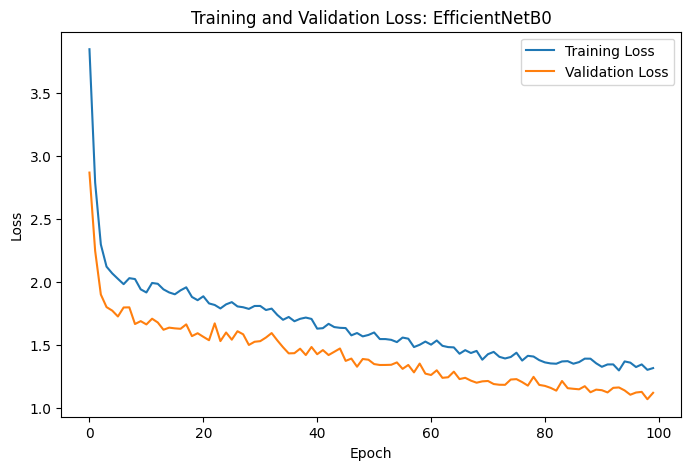

In [62]:
# Training EfficientNetB0 with loss visualization
run_model(EfficientNetB0, input_shape, num_classes)


Training VGG16
Epoch 1/100


608/608 - 457s - 751ms/step - accuracy: 0.3144 - loss: 3.7959 - val_accuracy: 0.4987 - val_loss: 2.9697
Epoch 2/100


608/608 - 491s - 807ms/step - accuracy: 0.4454 - loss: 2.8242 - val_accuracy: 0.5697 - val_loss: 2.2853
Epoch 3/100


608/608 - 368s - 606ms/step - accuracy: 0.4997 - loss: 2.3402 - val_accuracy: 0.6276 - val_loss: 1.9300
Epoch 4/100


608/608 - 364s - 599ms/step - accuracy: 0.5237 - loss: 2.1138 - val_accuracy: 0.6342 - val_loss: 1.7792
Epoch 5/100


608/608 - 364s - 599ms/step - accuracy: 0.5283 - loss: 2.0083 - val_accuracy: 0.6763 - val_loss: 1.6570
Epoch 6/100
608/608 - 401s - 659ms/step - accuracy: 0.5362 - loss: 1.9495 - val_accuracy: 0.6263 - val_loss: 1.6758
Epoch 7/100


608/608 - 865s - 1s/step - accuracy: 0.5342 - loss: 1.8914 - val_accuracy: 0.6250 - val_loss: 1.6419
Epoch 8/100
608/608 - 408s - 671ms/step - accuracy: 0.5537 - loss: 1.8497 - val_accuracy: 0.6132 - val_loss: 1.6891
Epoch 9/100


608/608 - 365s - 601ms/step - accuracy: 0.5352 - loss: 1.8585 - val_accuracy: 0.6329 - val_loss: 1.6054
Epoch 10/100


608/608 - 368s - 605ms/step - accuracy: 0.5543 - loss: 1.8525 - val_accuracy: 0.6500 - val_loss: 1.5685
Epoch 11/100
608/608 - 516s - 849ms/step - accuracy: 0.5566 - loss: 1.8325 - val_accuracy: 0.6355 - val_loss: 1.6311
Epoch 12/100
608/608 - 366s - 602ms/step - accuracy: 0.5592 - loss: 1.8220 - val_accuracy: 0.6408 - val_loss: 1.6119
Epoch 13/100
608/608 - 380s - 625ms/step - accuracy: 0.5843 - loss: 1.7911 - val_accuracy: 0.6566 - val_loss: 1.5741
Epoch 14/100
608/608 - 376s - 618ms/step - accuracy: 0.5563 - loss: 1.8376 - val_accuracy: 0.6487 - val_loss: 1.6130
Epoch 15/100
608/608 - 385s - 634ms/step - accuracy: 0.5471 - loss: 1.8448 - val_accuracy: 0.6263 - val_loss: 1.6110
Epoch 16/100
608/608 - 335s - 550ms/step - accuracy: 0.5586 - loss: 1.8160 - val_accuracy: 0.6237 - val_loss: 1.6196
Epoch 17/100
608/608 - 335s - 551ms/step - accuracy: 0.5658 - loss: 1.7952 - val_accuracy: 0.6395 - val_loss: 1.6339
Epoch 18/100


608/608 - 360s - 592ms/step - accuracy: 0.5589 - loss: 1.7974 - val_accuracy: 0.6513 - val_loss: 1.5586
Epoch 19/100


608/608 - 346s - 570ms/step - accuracy: 0.5517 - loss: 1.7996 - val_accuracy: 0.6566 - val_loss: 1.5384
Epoch 20/100
608/608 - 343s - 564ms/step - accuracy: 0.5527 - loss: 1.7838 - val_accuracy: 0.6289 - val_loss: 1.5404
Epoch 21/100
608/608 - 425s - 700ms/step - accuracy: 0.5652 - loss: 1.7754 - val_accuracy: 0.6408 - val_loss: 1.5635
Epoch 22/100


608/608 - 479s - 787ms/step - accuracy: 0.5849 - loss: 1.7390 - val_accuracy: 0.6500 - val_loss: 1.5195
Epoch 23/100
608/608 - 459s - 755ms/step - accuracy: 0.5731 - loss: 1.7828 - val_accuracy: 0.6763 - val_loss: 1.5510
Epoch 24/100
608/608 - 466s - 766ms/step - accuracy: 0.5658 - loss: 1.7674 - val_accuracy: 0.6592 - val_loss: 1.5220
Epoch 25/100


608/608 - 436s - 718ms/step - accuracy: 0.5540 - loss: 1.7800 - val_accuracy: 0.6671 - val_loss: 1.5115
Epoch 26/100
608/608 - 439s - 722ms/step - accuracy: 0.5616 - loss: 1.7782 - val_accuracy: 0.6461 - val_loss: 1.5229
Epoch 27/100
608/608 - 441s - 726ms/step - accuracy: 0.5576 - loss: 1.7694 - val_accuracy: 0.6658 - val_loss: 1.5151
Epoch 28/100
608/608 - 436s - 716ms/step - accuracy: 0.5668 - loss: 1.7542 - val_accuracy: 0.6684 - val_loss: 1.5248
Epoch 29/100


608/608 - 444s - 730ms/step - accuracy: 0.5678 - loss: 1.7388 - val_accuracy: 0.6671 - val_loss: 1.4988
Epoch 30/100
608/608 - 386s - 635ms/step - accuracy: 0.5737 - loss: 1.7258 - val_accuracy: 0.6671 - val_loss: 1.5081
Epoch 31/100
608/608 - 420s - 690ms/step - accuracy: 0.5546 - loss: 1.7842 - val_accuracy: 0.6789 - val_loss: 1.5053
Epoch 32/100
608/608 - 422s - 693ms/step - accuracy: 0.5606 - loss: 1.7482 - val_accuracy: 0.6513 - val_loss: 1.5121
Epoch 33/100
608/608 - 418s - 688ms/step - accuracy: 0.5622 - loss: 1.7554 - val_accuracy: 0.6408 - val_loss: 1.5217
Epoch 34/100
608/608 - 399s - 657ms/step - accuracy: 0.5721 - loss: 1.7343 - val_accuracy: 0.6303 - val_loss: 1.5161
Epoch 35/100


608/608 - 410s - 674ms/step - accuracy: 0.5639 - loss: 1.7413 - val_accuracy: 0.6855 - val_loss: 1.4804
Epoch 36/100
608/608 - 398s - 655ms/step - accuracy: 0.5711 - loss: 1.7170 - val_accuracy: 0.6553 - val_loss: 1.5004
Epoch 37/100
608/608 - 452s - 744ms/step - accuracy: 0.5586 - loss: 1.7235 - val_accuracy: 0.6434 - val_loss: 1.5087
Epoch 38/100
608/608 - 396s - 652ms/step - accuracy: 0.5645 - loss: 1.7276 - val_accuracy: 0.6382 - val_loss: 1.5273
Epoch 39/100


608/608 - 431s - 709ms/step - accuracy: 0.5652 - loss: 1.7445 - val_accuracy: 0.6645 - val_loss: 1.4758
Epoch 40/100
608/608 - 375s - 618ms/step - accuracy: 0.5704 - loss: 1.7051 - val_accuracy: 0.6461 - val_loss: 1.5195
Epoch 41/100
608/608 - 384s - 632ms/step - accuracy: 0.5546 - loss: 1.7440 - val_accuracy: 0.6447 - val_loss: 1.5207
Epoch 42/100
608/608 - 384s - 632ms/step - accuracy: 0.5635 - loss: 1.7079 - val_accuracy: 0.6539 - val_loss: 1.4812
Epoch 43/100
608/608 - 404s - 665ms/step - accuracy: 0.5632 - loss: 1.7087 - val_accuracy: 0.6526 - val_loss: 1.5244
Epoch 44/100


608/608 - 453s - 745ms/step - accuracy: 0.5688 - loss: 1.7191 - val_accuracy: 0.6474 - val_loss: 1.4594
Epoch 45/100
608/608 - 403s - 663ms/step - accuracy: 0.5691 - loss: 1.7022 - val_accuracy: 0.6711 - val_loss: 1.4853
Epoch 46/100
608/608 - 415s - 683ms/step - accuracy: 0.5658 - loss: 1.7405 - val_accuracy: 0.6724 - val_loss: 1.5049
Epoch 47/100
608/608 - 392s - 644ms/step - accuracy: 0.5629 - loss: 1.7133 - val_accuracy: 0.6737 - val_loss: 1.4613
Epoch 48/100
608/608 - 412s - 677ms/step - accuracy: 0.5599 - loss: 1.7052 - val_accuracy: 0.6711 - val_loss: 1.4800
Epoch 49/100
608/608 - 387s - 636ms/step - accuracy: 0.5645 - loss: 1.7157 - val_accuracy: 0.6500 - val_loss: 1.5032
Epoch 50/100


608/608 - 318s - 523ms/step - accuracy: 0.5652 - loss: 1.7241 - val_accuracy: 0.6776 - val_loss: 1.4519
Epoch 51/100
608/608 - 337s - 554ms/step - accuracy: 0.5662 - loss: 1.6696 - val_accuracy: 0.6579 - val_loss: 1.4653
Epoch 52/100
608/608 - 355s - 584ms/step - accuracy: 0.5629 - loss: 1.6990 - val_accuracy: 0.6434 - val_loss: 1.4583
Epoch 53/100


608/608 - 331s - 544ms/step - accuracy: 0.5757 - loss: 1.6723 - val_accuracy: 0.6539 - val_loss: 1.4348
Epoch 54/100


608/608 - 337s - 554ms/step - accuracy: 0.5836 - loss: 1.6520 - val_accuracy: 0.6513 - val_loss: 1.4245
Epoch 55/100


608/608 - 433s - 711ms/step - accuracy: 0.5737 - loss: 1.6820 - val_accuracy: 0.6632 - val_loss: 1.4026
Epoch 56/100
608/608 - 458s - 753ms/step - accuracy: 0.5810 - loss: 1.6395 - val_accuracy: 0.6645 - val_loss: 1.4281
Epoch 57/100
608/608 - 448s - 736ms/step - accuracy: 0.5523 - loss: 1.6556 - val_accuracy: 0.6658 - val_loss: 1.4538
Epoch 58/100
608/608 - 446s - 734ms/step - accuracy: 0.5645 - loss: 1.6512 - val_accuracy: 0.6395 - val_loss: 1.4489
Epoch 59/100
608/608 - 463s - 762ms/step - accuracy: 0.5612 - loss: 1.6819 - val_accuracy: 0.6447 - val_loss: 1.4598
Epoch 60/100
608/608 - 485s - 798ms/step - accuracy: 0.5859 - loss: 1.6362 - val_accuracy: 0.6421 - val_loss: 1.4663
Epoch 61/100
608/608 - 445s - 732ms/step - accuracy: 0.5711 - loss: 1.6427 - val_accuracy: 0.6447 - val_loss: 1.4460
Epoch 62/100
608/608 - 404s - 664ms/step - accuracy: 0.5727 - loss: 1.6372 - val_accuracy: 0.6461 - val_loss: 1.4203
Epoch 63/100
608/608 - 428s - 705ms/step - accuracy: 0.5764 - loss: 1.6447 - 

608/608 - 400s - 658ms/step - accuracy: 0.5770 - loss: 1.6308 - val_accuracy: 0.6513 - val_loss: 1.3975
Epoch 65/100
608/608 - 390s - 642ms/step - accuracy: 0.5714 - loss: 1.6548 - val_accuracy: 0.6447 - val_loss: 1.4566
Epoch 66/100
608/608 - 390s - 642ms/step - accuracy: 0.5856 - loss: 1.6229 - val_accuracy: 0.6329 - val_loss: 1.4373
Epoch 67/100
608/608 - 388s - 639ms/step - accuracy: 0.5704 - loss: 1.6386 - val_accuracy: 0.6474 - val_loss: 1.4228
Epoch 68/100


608/608 - 389s - 640ms/step - accuracy: 0.5760 - loss: 1.6001 - val_accuracy: 0.6513 - val_loss: 1.3807
Epoch 69/100
608/608 - 436s - 717ms/step - accuracy: 0.5754 - loss: 1.6422 - val_accuracy: 0.6474 - val_loss: 1.4117
Epoch 70/100
608/608 - 429s - 706ms/step - accuracy: 0.5813 - loss: 1.6124 - val_accuracy: 0.6592 - val_loss: 1.3872
Epoch 71/100


608/608 - 449s - 738ms/step - accuracy: 0.5681 - loss: 1.6195 - val_accuracy: 0.6579 - val_loss: 1.3771
Epoch 72/100
608/608 - 398s - 655ms/step - accuracy: 0.5843 - loss: 1.5933 - val_accuracy: 0.6395 - val_loss: 1.3923
Epoch 73/100
608/608 - 393s - 647ms/step - accuracy: 0.5760 - loss: 1.6102 - val_accuracy: 0.6671 - val_loss: 1.4128
Epoch 74/100
608/608 - 391s - 643ms/step - accuracy: 0.5721 - loss: 1.5967 - val_accuracy: 0.6553 - val_loss: 1.3946
Epoch 75/100
608/608 - 394s - 649ms/step - accuracy: 0.5816 - loss: 1.5947 - val_accuracy: 0.6447 - val_loss: 1.3964
Epoch 76/100


608/608 - 393s - 647ms/step - accuracy: 0.5823 - loss: 1.5782 - val_accuracy: 0.6737 - val_loss: 1.3601
Epoch 77/100
608/608 - 434s - 714ms/step - accuracy: 0.5754 - loss: 1.5786 - val_accuracy: 0.6487 - val_loss: 1.3906
Epoch 78/100
608/608 - 394s - 647ms/step - accuracy: 0.5747 - loss: 1.5839 - val_accuracy: 0.6316 - val_loss: 1.3982
Epoch 79/100
608/608 - 395s - 650ms/step - accuracy: 0.5823 - loss: 1.5888 - val_accuracy: 0.6539 - val_loss: 1.3784
Epoch 80/100
608/608 - 394s - 648ms/step - accuracy: 0.5866 - loss: 1.5716 - val_accuracy: 0.6474 - val_loss: 1.3801
Epoch 81/100
608/608 - 396s - 651ms/step - accuracy: 0.5777 - loss: 1.5696 - val_accuracy: 0.6487 - val_loss: 1.3836
Epoch 82/100
608/608 - 400s - 657ms/step - accuracy: 0.5688 - loss: 1.5883 - val_accuracy: 0.6382 - val_loss: 1.4001
Epoch 83/100


608/608 - 395s - 650ms/step - accuracy: 0.5757 - loss: 1.5749 - val_accuracy: 0.6303 - val_loss: 1.3586
Epoch 84/100
608/608 - 396s - 652ms/step - accuracy: 0.5793 - loss: 1.5746 - val_accuracy: 0.6289 - val_loss: 1.4126
Epoch 85/100


608/608 - 397s - 653ms/step - accuracy: 0.5635 - loss: 1.5949 - val_accuracy: 0.6605 - val_loss: 1.3473
Epoch 86/100
608/608 - 393s - 646ms/step - accuracy: 0.5721 - loss: 1.5799 - val_accuracy: 0.6513 - val_loss: 1.3649
Epoch 87/100
608/608 - 392s - 645ms/step - accuracy: 0.5839 - loss: 1.5319 - val_accuracy: 0.6342 - val_loss: 1.3515
Epoch 88/100
608/608 - 391s - 643ms/step - accuracy: 0.5945 - loss: 1.5263 - val_accuracy: 0.6684 - val_loss: 1.3613
Epoch 89/100
608/608 - 391s - 644ms/step - accuracy: 0.5708 - loss: 1.5699 - val_accuracy: 0.6263 - val_loss: 1.3689
Epoch 90/100
608/608 - 393s - 646ms/step - accuracy: 0.5658 - loss: 1.5688 - val_accuracy: 0.6368 - val_loss: 1.3713
Epoch 91/100
608/608 - 391s - 643ms/step - accuracy: 0.5741 - loss: 1.5807 - val_accuracy: 0.6539 - val_loss: 1.3595
Epoch 92/100
608/608 - 392s - 645ms/step - accuracy: 0.5816 - loss: 1.5359 - val_accuracy: 0.6566 - val_loss: 1.3644
Epoch 93/100
608/608 - 392s - 645ms/step - accuracy: 0.5747 - loss: 1.5498 - 

608/608 - 392s - 645ms/step - accuracy: 0.5806 - loss: 1.5430 - val_accuracy: 0.6632 - val_loss: 1.3342
Epoch 95/100
608/608 - 409s - 672ms/step - accuracy: 0.5704 - loss: 1.5239 - val_accuracy: 0.6382 - val_loss: 1.3742
Epoch 96/100
608/608 - 562s - 925ms/step - accuracy: 0.5770 - loss: 1.5472 - val_accuracy: 0.6289 - val_loss: 1.3573
Epoch 97/100


608/608 - 463s - 762ms/step - accuracy: 0.5744 - loss: 1.5343 - val_accuracy: 0.6434 - val_loss: 1.3289
Epoch 98/100
608/608 - 459s - 755ms/step - accuracy: 0.5747 - loss: 1.5254 - val_accuracy: 0.6355 - val_loss: 1.3347
Epoch 99/100
608/608 - 465s - 765ms/step - accuracy: 0.5922 - loss: 1.5220 - val_accuracy: 0.6500 - val_loss: 1.3396
Epoch 100/100
608/608 - 463s - 762ms/step - accuracy: 0.5826 - loss: 1.5178 - val_accuracy: 0.6329 - val_loss: 1.3323


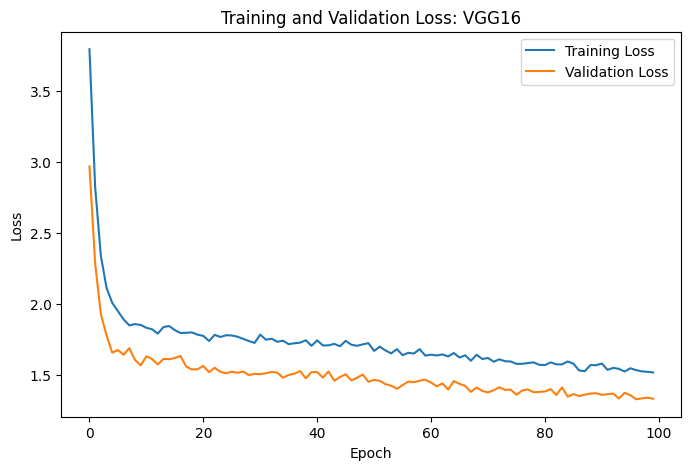

In [72]:
# Training VGG16 with loss visualization
run_model(VGG16, input_shape, num_classes)

#### (1)(c)(v) Report training, validation, and test Precision, Recall, AUC and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [74]:
# Evaluating model performance: Precision, Recall, F1 score, and AUC
def evaluate_model(model, X, y_true, average='macro'):
    y_pred_probs = model.predict(X)
    y_pred = y_pred_probs.argmax(axis=1)
    y_true_indices = y_true.argmax(axis=1)
    
    precision = precision_score(y_true_indices, y_pred, average=average)
    recall = recall_score(y_true_indices, y_pred, average=average)
    f1 = f1_score(y_true_indices, y_pred, average=average)
    # For multi-class AUC, use 'ovr' (one-vs-rest)
    try:
        auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr', average=average)
    except Exception as e:
        auc = None  # Sometimes AUC can't be computed if a class is missing in y_true
    return precision, recall, f1, auc

In [78]:
# Evaluating each model's performance on train, validation, and test splits
model_names = ["ResNet50", "ResNet101", "EfficientNetB0", "VGG16"]
results = {}

for name in model_names:
    print(f"\nEvaluating {name}...")
    model = tf.keras.models.load_model(f'best_{name}.h5')
    metrics = {}
    for split, (X_train_augmented, y_train) in {
        "Train": (X_train_split, y_train_split),
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test)
    }.items():
        precision, recall, f1, auc = evaluate_model(model, X_train_augmented, y_train)
        metrics[split] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "AUC": auc
        }
        print(f"{split}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc:.4f}" if auc is not None else
              f"{split}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC=N/A")
    results[name] = metrics


Evaluating ResNet50...


95/95 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step
Train: Precision=0.8407, Recall=0.8236, F1=0.8295, AUC=0.9824
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
Validation: Precision=0.7246, Recall=0.7132, F1=0.7153, AUC=0.9551
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Test: Precision=0.6475, Recall=0.6572, F1=0.6183, AUC=0.9400

Evaluating ResNet101...


95/95 ━━━━━━━━━━━━━━━━━━━━ 268s 3s/step
Train: Precision=0.8413, Recall=0.8355, F1=0.8367, AUC=0.9834
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step
Validation: Precision=0.7073, Recall=0.7064, F1=0.7047, AUC=0.9494
30/30 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step
Test: Precision=0.6534, Recall=0.6616, F1=0.6360, AUC=0.9406

Evaluating EfficientNetB0...


95/95 ━━━━━━━━━━━━━━━━━━━━ 44s 442ms/step
Train: Precision=0.7581, Recall=0.7381, F1=0.7356, AUC=0.9673
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step
Validation: Precision=0.6701, Recall=0.6509, F1=0.6470, AUC=0.9390
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 455ms/step
Test: Precision=0.6795, Recall=0.6664, F1=0.6497, AUC=0.9380

Evaluating VGG16...


95/95 ━━━━━━━━━━━━━━━━━━━━ 389s 4s/step
Train: Precision=0.7489, Recall=0.7235, F1=0.7274, AUC=0.9634
24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step
Validation: Precision=0.6611, Recall=0.6413, F1=0.6429, AUC=0.9335
30/30 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step
Test: Precision=0.6043, Recall=0.5557, F1=0.5643, AUC=0.9273


**Conclusion :**
1. ResNet101 achieved Precision 0.6534, Recall 0.6616, F1 0.6360 and AUC 0.9406, showing strong and consistent performance overall.

2. ResNet50 showed decent results with Precision 0.6475, Recall 0.6572, F1 0.6183 and AUC 0.9400, slightly below ResNet101.

3. EfficientNetB0 had the highest Precision 0.6795 and F1 0.6497, with Recall 0.6664 and AUC 0.9380, indicating strong generalization.

4. VGG16 performed worst with Precision 0.6043, Recall 0.5557, F1 0.5643 and AUC 0.9273, showing poor test performance.ent.

**References :**

1. **TensorFlow Keras Model :**
   Keras is used for building deep learning models, including creating and compiling the transfer learning model.

   * Keras Model: https://www.tensorflow.org/api_docs/python/tf/keras/models/Model

2. **EarlyStopping Callback :**
   EarlyStopping is used for monitoring the validation loss during training and stopping the training if the performance stops improving.

   * EarlyStopping: [https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

3. **ModelCheckpoint Callback :**
   ModelCheckpoint is used for saving the best model based on the validation loss during training.

   * ModelCheckpoint: [https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)

4. **scikit-learn Precision, Recall, F1, and AUC Scores :**
   These metrics are used to evaluate the performance of the model on different splits (train, validation, and test).

   * Precision, Recall, F1, and AUC Scores: [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)